In [115]:
import pandas as pd

from numpy import random

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  

import re

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

In [2]:
random.seed(0)

# Читаем данные

[Ссылка на датасет](https://www.kaggle.com/competitions/nlp-getting-started/data)

In [3]:
data = pd.read_csv('train.csv') 

In [4]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
data.shape

(7613, 5)

In [6]:
data.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

In [7]:
data.target.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [8]:
for i in range(10, 15):
    print(data.text.iloc[i], end='\n\n')

Three people died from the heat wave so far

Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding

#raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count 

#Flood in Bago Myanmar #We arrived Bago

Damage to school bus on 80 in multi car crash #BREAKING 



# Очистка текста

In [9]:
lemmatizer = WordNetLemmatizer() 
stop_words = stopwords.words('english')


def make_lower(text):
    return text.lower()

def remove_urls(text):
    return re.sub(r'http\S+', '', text)

def only_letters(text):
    return re.sub(r"[^a-zA-Z]+", " ", text)

def lemmatize(text):
    text = text.split()
    return [lemmatizer.lemmatize(word) for word in text]

def remove_stop_words(text):
    return [word for word in text if word not in stop_words]

def preprocess_text(text):
    text = make_lower(text)
    text = remove_urls(text)
    text = only_letters(text)
    text = lemmatize(text)
    text = remove_stop_words(text)
    return ' '.join(text)

In [10]:
data['text'] = data['text'].apply(preprocess_text)

In [11]:
for i in range(10, 15):
    print(data.text.iloc[i], end='\n\n')

three people died heat wave far

haha south tampa getting flooded hah wait second live south tampa gonna gonna fvck flooding

raining flooding florida tampabay tampa day lost count

flood bago myanmar arrived bago

damage school bus multi car crash breaking



In [12]:
X = data.text
y = data.target

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=12)

# CountVectorizer

In [133]:
vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=5, max_df=100)

In [134]:
X_transformed = vectorizer.fit_transform(X_train)

In [135]:
X_transformed

<5709x2675 sparse matrix of type '<class 'numpy.int64'>'
	with 39048 stored elements in Compressed Sparse Row format>

In [136]:
X_transformed.max()

13

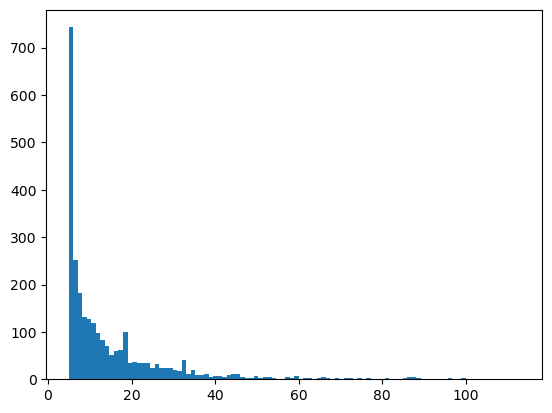

In [137]:
plt.hist(X_transformed.toarray().sum(axis=0), bins=100);

In [138]:
X_transformed = X_transformed.toarray()

In [139]:
logreg = LogisticRegression()
logreg.fit(X_transformed, y_train)
print(classification_report(y_train, logreg.predict(X_transformed)))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      3256
           1       0.93      0.81      0.86      2453

    accuracy                           0.89      5709
   macro avg       0.90      0.88      0.89      5709
weighted avg       0.89      0.89      0.89      5709



In [140]:
print(classification_report(y_test, logreg.predict(vectorizer.transform(X_test))))

              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1086
           1       0.81      0.72      0.76       818

    accuracy                           0.81      1904
   macro avg       0.81      0.79      0.80      1904
weighted avg       0.81      0.81      0.80      1904



# TF-IDF

In [141]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=100)
X_transformed = tfidf.fit_transform(X_train)
X_transformed = X_transformed.toarray()
logreg = LogisticRegression()
logreg.fit(X_transformed, y_train)
print(classification_report(y_train, logreg.predict(X_transformed)))

              precision    recall  f1-score   support

           0       0.83      0.94      0.89      3256
           1       0.91      0.75      0.82      2453

    accuracy                           0.86      5709
   macro avg       0.87      0.85      0.85      5709
weighted avg       0.87      0.86      0.86      5709



In [142]:
print(classification_report(y_test, logreg.predict(tfidf.transform(X_test))))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1086
           1       0.82      0.70      0.76       818

    accuracy                           0.81      1904
   macro avg       0.81      0.79      0.80      1904
weighted avg       0.81      0.81      0.80      1904



# SVD

In [143]:
model = Pipeline(
    steps=[
        ['tfidf', TfidfVectorizer(ngram_range=(1, 3), min_df=1)],
        ['svd', TruncatedSVD(1000)],
        ['logreg', LogisticRegression()]
    ]
)

In [144]:
model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('svd', TruncatedSVD(n_components=1000)),
                ['logreg', LogisticRegression()]])

In [145]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.78      0.96      0.86      3256
           1       0.93      0.63      0.75      2453

    accuracy                           0.82      5709
   macro avg       0.85      0.80      0.81      5709
weighted avg       0.84      0.82      0.81      5709



In [146]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1086
           1       0.85      0.65      0.74       818

    accuracy                           0.80      1904
   macro avg       0.81      0.78      0.79      1904
weighted avg       0.81      0.80      0.80      1904



In [154]:
model = Pipeline(
    steps=[
        ['tfidf', TfidfVectorizer()],
        ['svd', TruncatedSVD()],
        ['logreg', LogisticRegression()]
    ]
)
param_grid = {
    'tfidf__ngram_range': [(1, 2), (1, 3)],
    'tfidf__min_df': [2, 3],
    'svd__n_components': [100, 500], 
    'logreg__C': [0.1, 1, 10]
}
cv = GridSearchCV(model, param_grid=param_grid, cv=3, n_jobs=2, scoring='f1')


In [155]:
cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[['tfidf', TfidfVectorizer()],
                                       ['svd', TruncatedSVD()],
                                       ['logreg', LogisticRegression()]]),
             n_jobs=2,
             param_grid={'logreg__C': [0.1, 1, 10],
                         'svd__n_components': [100, 500],
                         'tfidf__min_df': [2, 3],
                         'tfidf__ngram_range': [(1, 2), (1, 3)]},
             scoring='f1')

In [156]:
cv.best_params_

{'logreg__C': 10,
 'svd__n_components': 500,
 'tfidf__min_df': 3,
 'tfidf__ngram_range': (1, 3)}

In [158]:
best_model = cv.best_estimator_

In [159]:
print(classification_report(y_train, best_model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      3256
           1       0.83      0.74      0.78      2453

    accuracy                           0.83      5709
   macro avg       0.83      0.82      0.82      5709
weighted avg       0.83      0.83      0.82      5709



In [160]:
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1086
           1       0.80      0.72      0.76       818

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.79      1904
weighted avg       0.80      0.80      0.80      1904

